In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import math
from PIL import Image, ImageDraw
import numpy as np

In [2]:
## Ellipsoid Parameters as tuples (semi major axis, inverse flattening)
WGS84 = (6378137, 298.257223563)

def geodetic_to_geocentric(lat, lon, ellps=WGS84):
    """
    Compute the Geocentric (Cartesian) Coordinates X, Y, Z
    given the Geodetic Coordinates lat, lon + Ellipsoid Height h
    """
    a, rf = ellps
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    N = a / math.sqrt(1 - (1 - (1 - 1 / rf) ** 2) * (math.sin(lat_rad)) ** 2)
    X = N * math.cos(lat_rad) * math.cos(lon_rad)
    Y = N * math.cos(lat_rad) * math.sin(lon_rad)

    return X, Y

In [3]:
df = pd.read_csv('../data/ref1.csv')
df['x'] = df.apply(lambda row: geodetic_to_geocentric(row['LAT'], row['LON'])[0], axis=1)
df['y'] = df.apply(lambda row: geodetic_to_geocentric(row['LAT'], row['LON'])[1], axis=1)

In [4]:
df.describe()

,LAT,LON,GSPEED,CRS,NLAT,NLON,NCRS,x,y
count,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1.420000e+03,1.420000e+03
mean,48.049092,17.568064,7.493394,171.055634,48.049092,17.568064,171.052529,4.072425e+06,1.289352e+06
std,0.000570,0.000655,2.273939,98.133474,0.000570,0.000655,98.132022,5.673723e+01,3.721080e+01
min,48.048012,17.566683,0.800000,0.089600,48.048012,17.566683,0.089600,4.072338e+06,1.289271e+06
25%,48.048608,17.567626,6.290000,62.484790,48.048608,17.567626,62.484790,4.072376e+06,1.289331e+06
50%,48.049179,17.568118,7.630000,193.969980,48.049179,17.568118,193.969980,4.072418e+06,1.289346e+06
75%,48.049537,17.568520,8.852500,230.770872,48.049537,17.568520,230.770872,4.072474e+06,1.289379e+06
max,48.050132,17.569315,12.950000,359.505750,48.050132,17.569315,359.505750,4.072529e+06,1.289430e+06


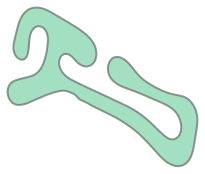

In [5]:
track = Polygon([(row['x'], row['y']) for index, row in df.iterrows()])
track

In [6]:
original_x_range = df['x'].max() - df['x'].min()
original_y_range = df['y'].max() - df['y'].min()
ratio_yx = original_y_range / original_x_range

<AxesSubplot:>

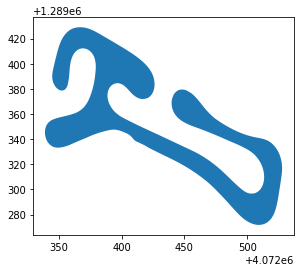

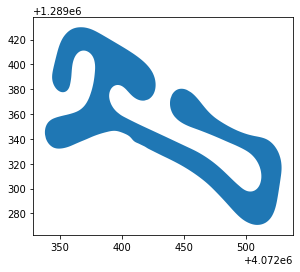

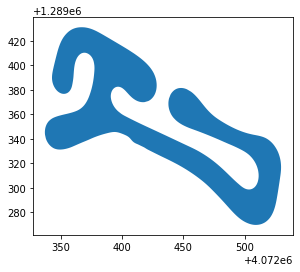

In [7]:
in_polygon = gpd.GeoSeries(track).buffer(-1.)
in_polygon.plot()
polygon = gpd.GeoSeries(track)
polygon.plot()
out_polygon = gpd.GeoSeries(track).buffer(1.)
out_polygon.plot()

In [8]:
in_coords = [list(map(np.float, x.split(' '))) for x in str(in_polygon[0]).strip('POLYGON ()').split(', ')]
out_coords = [list(map(np.float, x.split(' '))) for x in str(out_polygon[0]).strip('POLYGON ()').split(', ')]

In [18]:
COLOR_GRASS = (65, 152, 10)
COLOR_GRASS_SPOT = (102, 172, 58)
COLOR_TRACK = (102, 102, 102)
IMG_SIZE = (100, int(100 * ratio_yx))
MARGIN_SIZE = IMG_SIZE[0]/10

In [19]:
x_old_range = df['x'].max() - df['x'].min()
x_new_range = IMG_SIZE[0] - 2 * MARGIN_SIZE

def new_x(value):
    return (((value - df['x'].min()) * x_new_range) / x_old_range) + MARGIN_SIZE

y_old_range = df['y'].max() - df['y'].min()
y_new_range = IMG_SIZE[1] - 2 * MARGIN_SIZE

def new_y(value):
    return (((value - df['y'].min()) * y_new_range) / y_old_range) + MARGIN_SIZE

# NewValue = (((OldValue - OldMin) * NewRange) / OldRange) + NewMin

In [20]:
def transform_y(value):
    return IMG_SIZE[1] - value

In [24]:
img = Image.new('RGB', IMG_SIZE, COLOR_GRASS)
draw = ImageDraw.Draw(img)

# track
draw.polygon([(new_x(x[0]), transform_y(new_y(x[1]))) for x in out_coords], fill=COLOR_TRACK, outline=COLOR_TRACK)
draw.polygon([(new_x(x[0]), transform_y(new_y(x[1]))) for x in in_coords], fill=COLOR_GRASS, outline=COLOR_GRASS)

rows_count = df.shape[0]

# red line in the middle of the track
for index, row in df.iterrows():
    x1 = round(new_x(row['x']))
    y1 = round(transform_y(new_y(row['y'])))
    x2 = round(new_x(df['x'][index + 1] if index < rows_count - 1 else df['x'][0]))
    y2 = round(transform_y(new_y(df['y'][index + 1] if index < rows_count - 1 else df['y'][0])))
    draw.line((x1, y1, x2, y2), fill='red')

img.show()

In [25]:
img.save('track_image.png', 'PNG')